# Dynamic Time Warping

Dynamic Time Warping is a technique which tries to fit one Curve onto another. It tells how expensive that "fitting" is and also which points on one curve corresponds to points on another curve. The neat thing about DTW is that the two curves can be of different size. You can check out more about DTW [here](https://www.youtube.com/watch?v=ERKDHZyZDwA).

> Please note that this Notebook is inspired by the awesome DTW Tutorials mentioned in the link above and borrows some stuff from this Notebook [here](https://github.com/kamperh/lecture_dtw_notebook/blob/main/dtw.ipynb)

## Implementation of DTW Algorithm

In [11]:
def dp(dist_mat):
    """
    This function was borred from here: https://github.com/kamperh/lecture_dtw_notebook/blob/main/dtw.ipynb
    """

    N, M = dist_mat.shape
    
    # Initialize the cost matrix
    cost_mat = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        cost_mat[i, 0] = np.inf
    for i in range(1, M + 1):
        cost_mat[0, i] = np.inf

    # Fill the cost matrix while keeping traceback information
    traceback_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],      # match (0)
                cost_mat[i, j + 1],  # insertion (1)
                cost_mat[i + 1, j]]  # deletion (2)
            i_penalty = np.argmin(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    # Traceback from bottom right
    i = N - 1
    j = M - 1
    path = [(i, j)]
    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]
        if tb_type == 0:
            # Match
            i = i - 1
            j = j - 1
        elif tb_type == 1:
            # Insertion
            i = i - 1
        elif tb_type == 2:
            # Deletion
            j = j - 1
        path.append((i, j))

    # Strip infinity edges from cost_mat before returning
    cost_mat = cost_mat[1:, 1:]
    return (path[::-1], cost_mat)

## Helper function to precalculate Distance Matrix used in DTW Algorithm

In [12]:
def calculate_dist_mat(x, y):
    N = x.shape[0]
    M = y.shape[0]
    dist_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            dist_mat[i, j] = abs(x[i] - y[j])
    return dist_mat

## Try out Algorithm
* Precalculate the Distance Matrix
* Run the DTW Algorithm for two datasets we wish to compare
* Get the Alignment Cost and Normalized Alignment Cost (tells us how "costly" is is to transform one dataset to another one)
* Show which points from one series map to points from another series

(-0.6000000000000001, 12.6, -2.75, 2.75)

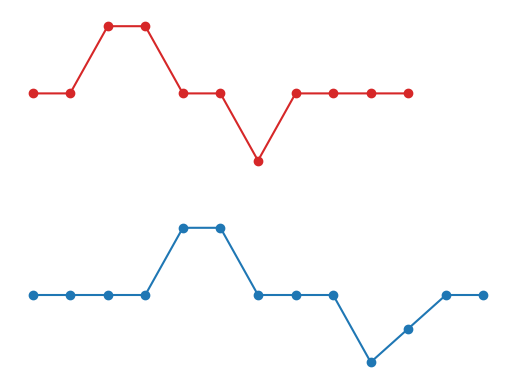

In [13]:
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np

PLOT_OFFSET = 1.5

x = np.array([0, 0, 1, 1, 0, 0, -1, 0, 0, 0, 0])
y = np.array([0, 0, 0, 0, 1, 1, 0, 0, 0, -1, -0.5, 0, 0])

plt.plot(np.arange(x.shape[0]), x + PLOT_OFFSET, "-o", c="C3")
plt.plot(np.arange(y.shape[0]), y - PLOT_OFFSET, "-o", c="C0")
plt.axis("off")


In [14]:
dist_mat = calculate_dist_mat(x, y)
N, M = dist_mat.shape
path, cost_mat = dp(dist_mat)
print("Alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]))
print("Normalized alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]/(N + M)))

Alignment cost: 0.5000
Normalized alignment cost: 0.0208


(-0.6000000000000001, 12.6, -2.75, 2.75)

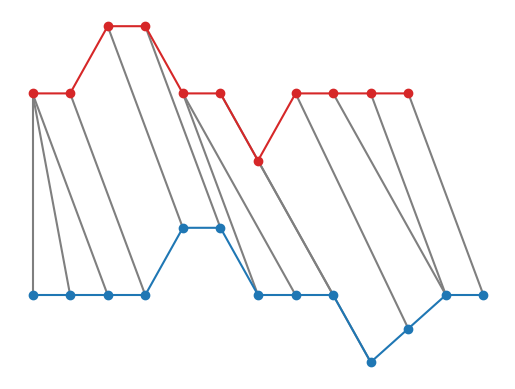

In [15]:
plt.figure()
for x_i, y_j in path:
    plt.plot([x_i, y_j], [x[x_i] + PLOT_OFFSET, y[y_j] - PLOT_OFFSET], c="C7")
plt.plot(np.arange(x.shape[0]), x + PLOT_OFFSET, "-o", c="C3")
plt.plot(np.arange(y.shape[0]), y - PLOT_OFFSET, "-o", c="C0")
plt.axis("off")

## Find most simlar Dataset

### Introduce Helper Method based on the code above

In [16]:
def compare_datasets(x, y):
    PLOT_OFFSET = 1.5
    dist_mat = calculate_dist_mat(x, y)
    N, M = dist_mat.shape
    path, cost_mat = dp(dist_mat)

    plt.figure()
    for x_i, y_j in path:
        plt.plot([x_i, y_j], [x[x_i] + PLOT_OFFSET, y[y_j] - PLOT_OFFSET], c="C7")
    plt.plot(np.arange(x.shape[0]), x + PLOT_OFFSET, "-o", c="C3")
    plt.plot(np.arange(y.shape[0]), y - PLOT_OFFSET, "-o", c="C0")
    plt.axis("off")
    
    print("Alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]))
    print("Normalized alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]/(N + M)))

Alignment cost: 2.5000
Normalized alignment cost: 0.1042
Alignment cost: 1.7500
Normalized alignment cost: 0.0972
Alignment cost: 0.5000
Normalized alignment cost: 0.0208


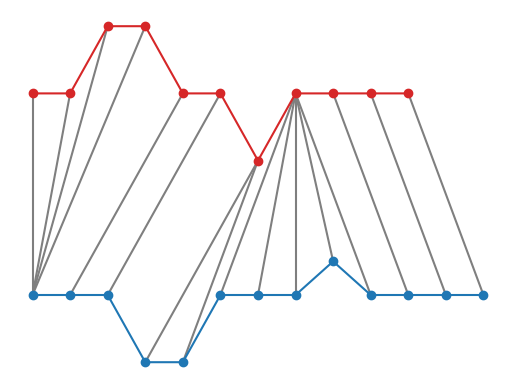

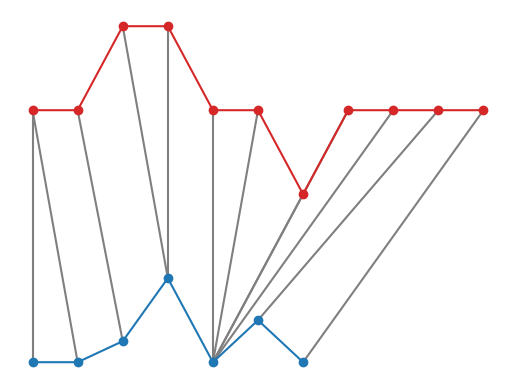

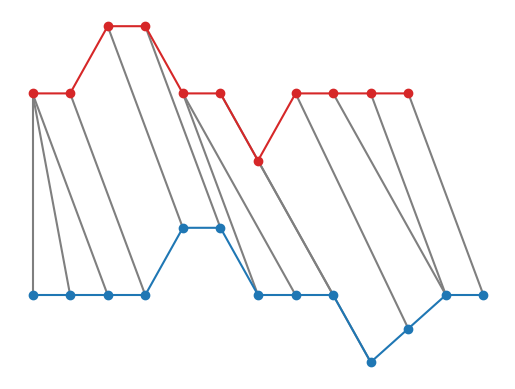

In [17]:
a = np.array([0, 0, 1, 1, 0, 0, -1, 0, 0, 0, 0])
b = np.array([0, 0, 0, 0, 1, 1, 0, 0, 0, -1, -0.5, 0, 0])
c = np.array([0, 0, 0, -1, -1, 0, 0, 0, 0.5, 0, 0, 0, 0])
d = np.array([0, 0, 0.25, 1, 0, 0.5, 0])
    
for compare_with in [c, d, b]:
    compare_datasets(a, compare_with)

## Load some Sample Data of a Tennis Move and use DTW on them

### Helper Methods

In [18]:
def create_df_from_tracking_data(tracking_data):
	df = []
	for frame in tracking_data.frameData:
		# For some reason we can get two elements in poseData which messes up the structure of the dataframe.
		# TODO: Check why we get two poses (e.g frame 21 in file ./data/test/track_data/guemah_forehand_flat_02out.pb)
		if len(frame.poseData) > 1:
			print(f"Got multiple pose data for frame {frame.index}")
		for pose in frame.poseData:
			# We are only interested in poses with id 0, skip the rest. This only occurs when we have multiple pose data per frame.
			if pose.id != 0:
				continue
			for keypoint in pose.keyPoints:
				# add frame and keypoint information to array
				df.append([frame.index, pose.id, keypoint.type, keypoint.posX, keypoint.posY, keypoint.absPosX, keypoint.absPosY, keypoint.absPosZ])

	df = pd.DataFrame(df, columns=["frame", "pose", "keypoint", "x", "y", "absX", "absY", "absZ"])
	df = df.pivot(index=["frame", "pose"], columns="keypoint", values=["x", "y", "absX", "absY", "absZ"])
	df = df.swaplevel(axis=1)
	return df

In [19]:
def load_tracking_data(file_path):
    with open(file_path, "rb") as f:
        # create tracking data object
        tracking_data = trackingDataPb_pb2.trackingData()
        
        # parse string from file
        tracking_data.ParseFromString(f.read())
    return tracking_data

### Compare some Key Points

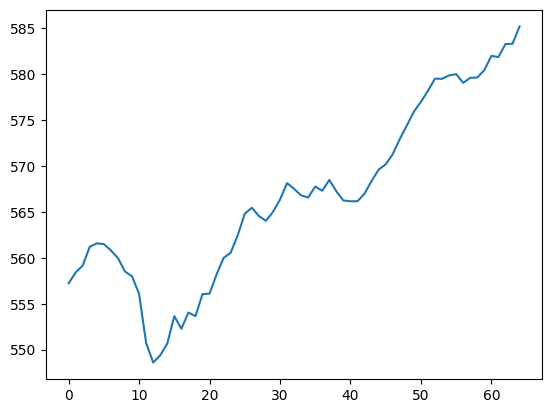

In [20]:
import trackingDataPb_pb2
import pandas as pd

file_path = "./data/features/backhand/track_data/guemah_backhand_01.pb"
tracking_data = load_tracking_data(file_path)
df = create_df_from_tracking_data(tracking_data)
kp1_x = df.loc[:,pd.IndexSlice[1,['x']]].values
plt.plot(kp1_x)

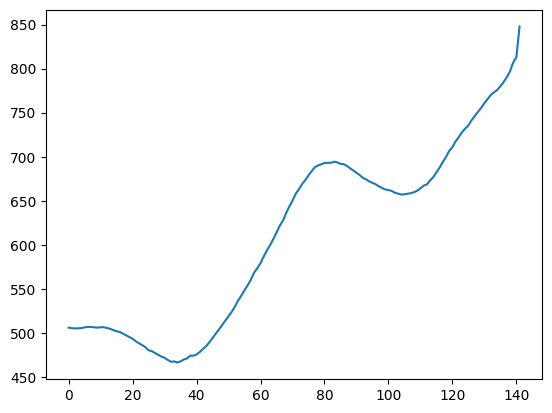

In [21]:
file_path = "./data/features/backhand/track_data/yhu_backhand_01.pb"
tracking_data = load_tracking_data(file_path)
df = create_df_from_tracking_data(tracking_data)
kp1_x = df.loc[:,pd.IndexSlice[1,['x']]].values
plt.plot(kp1_x)

In [22]:
def get_feature_keypoints_from_pb_files(file_path_a, file_path_b, keypoint, feature):
    
    tracking_data_a = load_tracking_data(file_path_a)
    tracking_data_b = load_tracking_data(file_path_b)
    
    df_a = create_df_from_tracking_data(tracking_data_a)
    df_b = create_df_from_tracking_data(tracking_data_b)

    kp_a = df_a.loc[:,pd.IndexSlice[keypoint,[feature]]].values.squeeze()
    kp_b = df_b.loc[:,pd.IndexSlice[keypoint,[feature]]].values.squeeze()
    return (kp_a, kp_b)

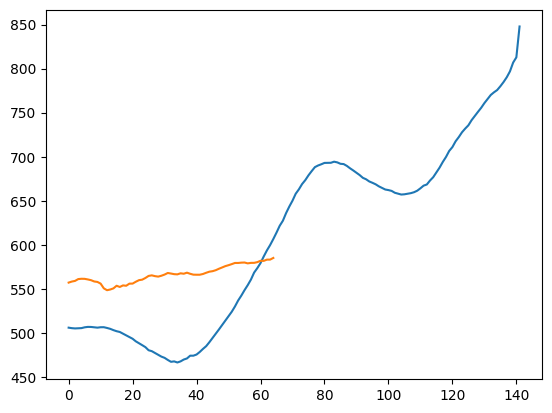

In [23]:
file_path_a = "./data/features/backhand/track_data/yhu_backhand_01.pb"
file_path_b = "./data/features/backhand/track_data/guemah_backhand_01.pb"
kp_a, kp_b = get_feature_keypoints_from_pb_files(file_path_a, file_path_b, 1, "x")

plt.plot(kp_a)
plt.plot(kp_b)

Alignment cost: 11894.6213
Normalized alignment cost: 57.4619


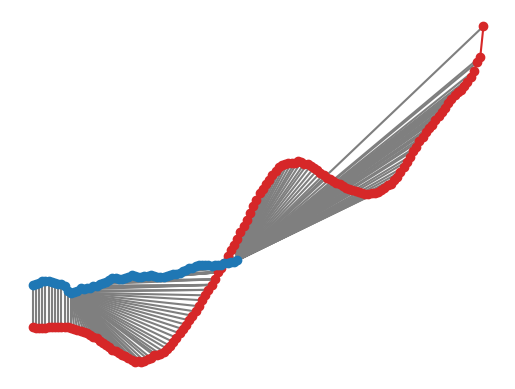

In [24]:
compare_datasets(kp_a, kp_b)

In [25]:
def compare_pb_files(file_path_a, file_path_b, keypoint, feature):
    kp_a, kp_b = get_feature_keypoints_from_pb_files(file_path_a, file_path_b, keypoint, feature)
    plt.plot(kp_a)
    plt.plot(kp_b)
    compare_datasets(kp_a, kp_b)

### X Coordinate

Alignment cost: 6808.2419
Normalized alignment cost: 32.8901


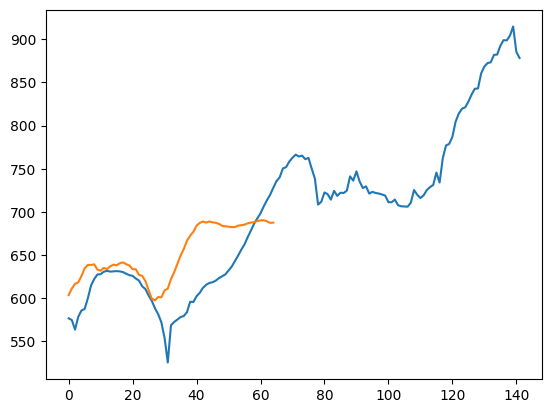

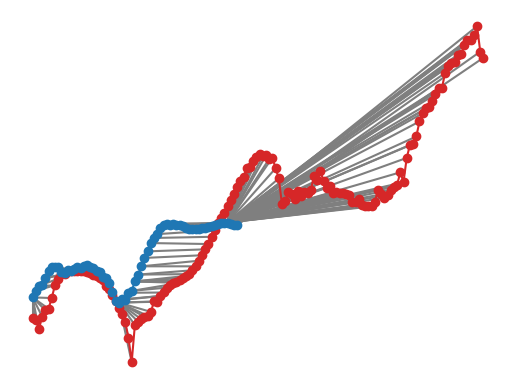

In [26]:
file_path_a = "./data/features/backhand/track_data/yhu_backhand_01.pb"
file_path_b = "./data/features/backhand/track_data/guemah_backhand_01.pb"
compare_pb_files(file_path_a, file_path_b, 20, "x")

### Y Coordinate

Alignment cost: 24493.9445
Normalized alignment cost: 118.3282


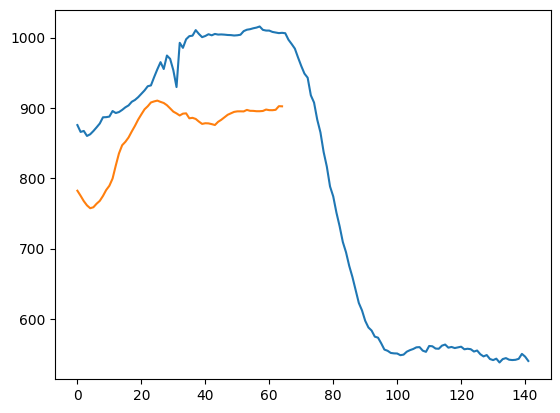

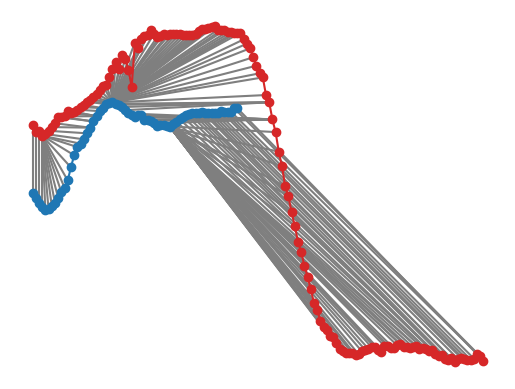

In [27]:
file_path_a = "./data/features/backhand/track_data/yhu_backhand_01.pb"
file_path_b = "./data/features/backhand/track_data/guemah_backhand_01.pb"
compare_pb_files(file_path_a, file_path_b, 20, "y")

### Velocity